In [99]:
import numpy as np
from collections import Counter
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial import Polynomial

In [100]:
class Num(float):
    counts = Counter(mul=0, add=0)
    def __add__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__add__(other))
    def __mul__(self, other):
        self.counts["mul"] += 1
        return Num(super(Num, self).__mul__(other))
    def __sub__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__sub__(other))
    def reset_counter(self):
        self.counts["mul"] = 0
        self.counts["add"] = 0


n = Num(9)
m = Num(18)
m += Num(18)
n += m

j = Num(90)
j += 1
j += 1
j += 1
j += 1
print(n, m.counts)

j.reset_counter()

45.0 Counter({'add': 6, 'mul': 0})


In [101]:
class MatrixMultiplier:

    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.result = np.zeros((1, 1), dtype=A.dtype)

    def is_power_of_two(self, n):
        if n == 1 or n == 0:
            return 0
        return (n & (n - 1)) == 0

    def matrix_partition_sq2(self, A):
        n = A.shape[0] // 2
        A11 = A[:n, :n]
        A12 = A[:n, n:]
        A21 = A[n:, :n]
        A22 = A[n:, n:]
        return A11, A12, A21, A22

    def matrix_repartition_sq2(self, A11, A12, A21, A22):
        C = np.block([[A11, A12],
                      [A21, A22]])
        return C

    def iterative_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if A.shape[0] == A.shape[1] and A.shape[1] == B.shape[0] and B.shape[0] == B.shape[1]:
            C = np.zeros((A.shape[0], B.shape[1]))
            for i in range(A.shape[0]):
                for j in range(B.shape[1]):
                    s = Num(0)
                    for k in range(B.shape[0]):
                        s += A[i, k] * B[k, j]
                    C[i, j] = s
        self.result = C
        return C

    def binet_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if A.shape[0] == A.shape[1] and A.shape[1] == B.shape[0] and B.shape[0] == B.shape[1]:
            if A.shape[0] == 1:
                return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
            elif self.is_power_of_two(B.shape[0]):
                A11, A12, A21, A22 = self.matrix_partition_sq2(A)
                B11, B12, B21, B22 = self.matrix_partition_sq2(B)
                C = self.matrix_repartition_sq2(self.binet_wrap(A11, B11) + self.binet_wrap(A12, B21),
                                                self.binet_wrap(A11, B12) + self.binet_wrap(A12, B22),
                                                self.binet_wrap(A21, B11) + self.binet_wrap(A22, B21),
                                                self.binet_wrap(A21, B12) + self.binet_wrap(A22, B22))

        return C
    def strassen_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if A.shape[0] == A.shape[1] and A.shape[1] == B.shape[0] and B.shape[0] == B.shape[1]:
            if A.shape[0] == 1:
                return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
            elif B.shape[0] > 1 and (B.shape[0] & (B.shape[0] - 1)) == 0:
                A11, A12, A21, A22 = self.matrix_partition_sq2(A)
                B11, B12, B21, B22 = self.matrix_partition_sq2(B)
                P1 = self.strassen_wrap(A11 + A22, B11 + B22)
                P2 = self.strassen_wrap(A21 + A22, B11)
                P3 = self.strassen_wrap(A11, B12 - B22)
                P4 = self.strassen_wrap(A22, B21 - B11)
                P5 = self.strassen_wrap(A11 + A12, B22)
                P6 = self.strassen_wrap(A21 - A11, B11 + B12)
                P7 = self.strassen_wrap(A12 - A22, B21 + B22)

                C = self.matrix_repartition_sq2(P1 + P4 - P5 + P7, P3 + P5,
                               P2 + P4, P1 - P2 + P3 + P6)

        return C
    def iterative(self):
        self.result = self.iterative_wrap(self.A, self.B)
        return self.result

    def strassen(self):
        self.result = self.strassen_wrap(self.A, self.B)
        return self.result

    def binet(self):
        self.result = self.binet_wrap(self.A, self.B)
        return self.result
    def reset_counter(self):
        Num().reset_counter()
    def check(self):
        return np.allclose(np.array(self.result, dtype=float), np.array(self.A@self.B, dtype=float), rtol=1e-05, atol=1e-08, equal_nan=False)
    def get_current_flops(self):
        return Num().counts


In [102]:
def create_M_2(n):
    n = 2 ** n
    return np.array([[Num((j * n + i + 1)/(n*n)) for i in range(n)] for j in range(n)], dtype=Num)

In [103]:
A = create_M_2(4)
B = create_M_2(4)
M = MatrixMultiplier(A, B)
M.reset_counter()
M.strassen()
print(M.get_current_flops())
M.reset_counter()
M.binet()
print(M.get_current_flops())

Counter({'add': 12870, 'mul': 2401})
Counter({'mul': 4096, 'add': 3840})


In [104]:
def test_functions(bound):
    df = pd.DataFrame()
    MM = MatrixMultiplier(create_M_2(1), create_M_2(1))
    for n in range(2, bound):
        MM.A, MM.B = create_M_2(n), create_M_2(n)
        methods = {"Iterative":MM.iterative, "Binet":MM.binet, "Strassen":MM.strassen}
        for method_name, method in methods.items():
            print(n, method_name)
            method()
            df.at[n, method_name] = MM.check()
    return df

In [105]:
def stat_functions(bound):
    df_times = pd.DataFrame()
    df_add = pd.DataFrame()
    df_mul = pd.DataFrame()
    MM = MatrixMultiplier(create_M_2(1), create_M_2(1))
    for n in range(2, bound):
        MM.A, MM.B = create_M_2(n), create_M_2(n)
        methods = {"Iterative":MM.iterative, "Binet":MM.binet, "Strassen":MM.strassen}
        for method_name, method in methods.items():
            MM.reset_counter()
            print(n, method_name[0], end=" ")
            start_time = time()
            method()
            df_times.at[n, method_name] = time() - start_time
            df_add.at[n, method_name] = MM.get_current_flops()["add"]
            df_mul.at[n, method_name] = MM.get_current_flops()["mul"]
    return df_times, df_add, df_mul

In [106]:
dfs = stat_functions(8)

1 I 1 B 1 S 2 I 2 B 2 S 3 I 3 B 3 S 4 I 4 B 4 S 5 I 5 B 5 S 6 I 6 B 6 S 7 I 7 B 7 S 

In [138]:
df = dfs[1]
def plot_stats(dfs):
    titles = ["Methods' times comparison", "Methods' addition counts comparison", "Methods' multiplication counts comparison"]
    y_labels = ["Time [s]", "Addition count", "Multiplication count"]
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
    for df, title, y_label, ax in zip(dfs, titles, y_labels, axes):
        # Polynomial interpolation and plotting
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        for method in df.columns:
            x = df.index
            y = df[method]

            # Polynomial interpolation
            coefficients = np.polyfit(x, y, len(x) - 1)
            polynomial = np.poly1d(coefficients)

            # Generate interpolated x values
            x_interp = np.linspace(min(x), max(x), 100)

            # Plot the interpolated curve
            ax.plot(x_interp, polynomial(x_interp), label=method)
            ax.scatter(x, y)

        # Set labels and title
        ax.set_xlabel('Size od matrices ($\log_2$ scale)')
        ax.set_ylabel(y_label)
        ax.set_title(title)

        # Show legend
        ax.legend()

        # Show the plot
    plt.tight_layout()
    plt.show()

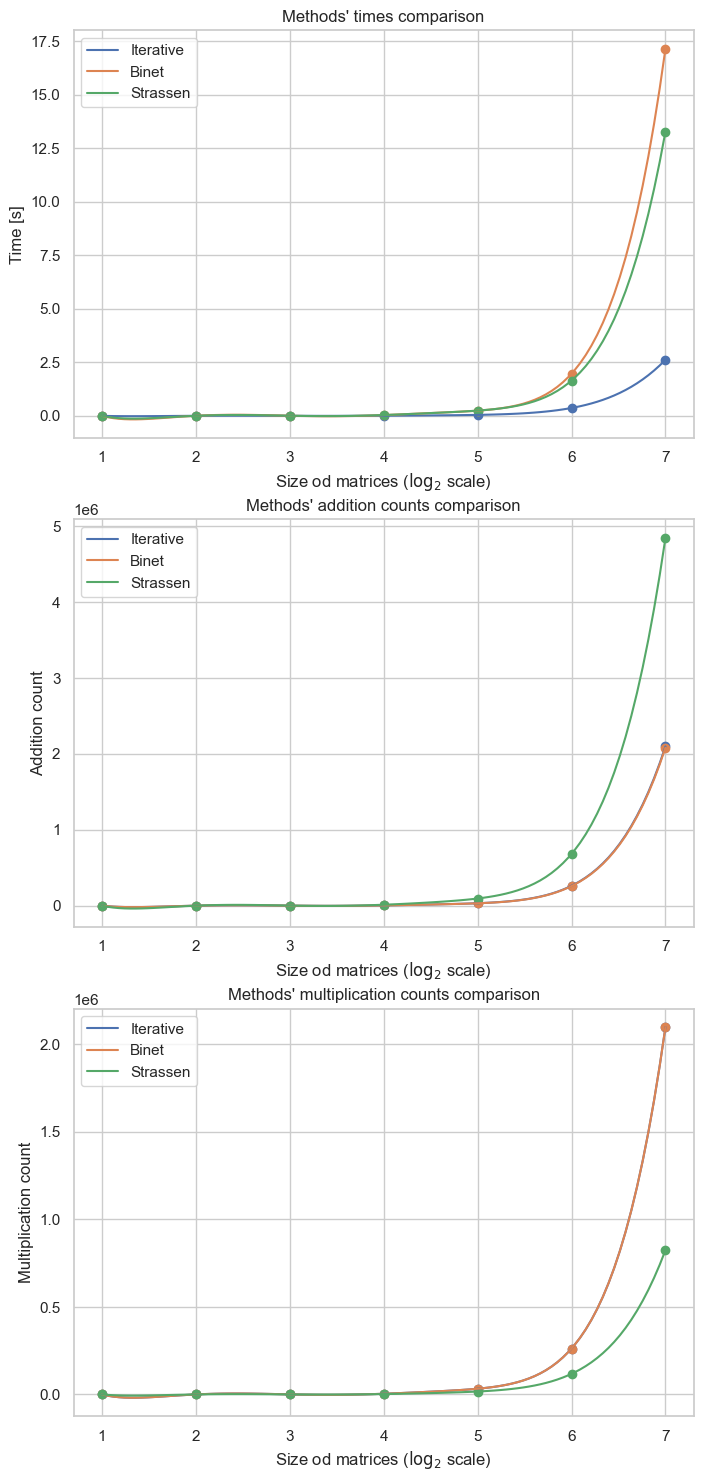

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [139]:
plot_stats(dfs)